In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clip
import os

In [2]:
dark_directory = "C:/kiavash/codes/Astro_Lab/hw10/dark"

flat_directory = "C:/kiavash/codes/Astro_Lab/hw10/flat/Flats_2.5"

flat_dark_directory = "C:/kiavash/codes/Astro_Lab/hw10/flat_dark/Darks_2.5"

bahram_directory = "C:/kiavash/codes/Astro_Lab/hw10/bahram"


In [3]:
def sigma_clipped_mean(stack, sigma=4.5, maxiters=2):
    clipped = sigma_clip(stack, sigma=sigma, maxiters=maxiters, axis=0)
    print("Clipped fraction:", np.mean(clipped.mask))
    return np.mean(clipped, axis=0)

def make_master_dark(dark_files):
    return sigma_clipped_mean(dark_files)

def make_master_flat(flat_dark, flat_files):
    corrected_flats = flat_files - flat_dark
    corrected_flats[corrected_flats < 1] = np.median(corrected_flats)
    master = sigma_clipped_mean(corrected_flats)
    return master / np.median(master)

def preprocess(master_dark, master_flat, images):
    results = []
    for image in images:
        result = (image - master_dark) / master_flat
        results.append(result)
    return(results)
    
def load_images(directory):
    images = []
    for file in os.listdir(directory):
        if file.endswith('.fit') or file.endswith('.fits'):
            data = fits.getdata(os.path.join(directory, file))
            images.append(data)
    return np.array(images)

Clipped fraction: 1.617981600313241e-08
min : 7.642295000000002
max : 172.56579499999998
avg : 47.77309805993206


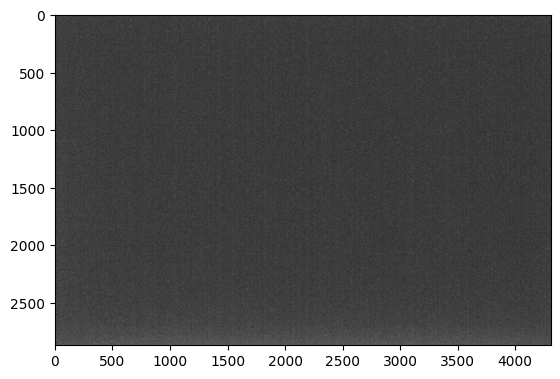

In [4]:
dark_files = load_images(dark_directory)
master_dark = make_master_dark(dark_files)

print("min :", master_dark.min())
print("max :", master_dark.max())
print("avg :", master_dark.mean())

plt.imshow(master_dark, cmap="gray")

Clipped fraction: 0.0
min : 2.906
max : 201.84106000000003
avg : 49.12294622573647


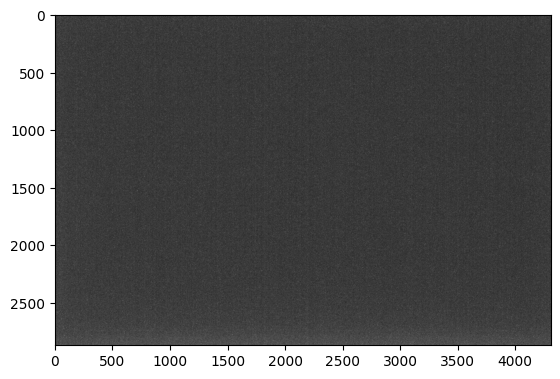

In [40]:
flat_dark_files = load_images(flat_dark_directory)
master_flat_dark = make_master_dark(flat_dark_files)

print("min :", master_flat_dark.min())
print("max :", master_flat_dark.max())
print("avg :", master_flat_dark.mean())

plt.imshow(master_flat_dark, cmap="gray")

C:\Users\ExoGame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Clipped fraction: 0.0
min : 0.045444385897527445
max : 1.6003612261317928
avg : 0.9809024384467695


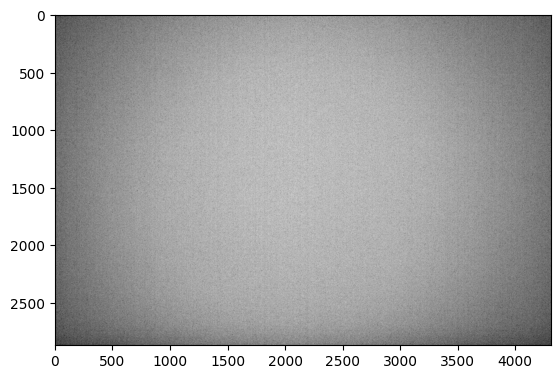

In [41]:
flat_files = load_images(flat_directory)
master_flat = make_master_flat(master_flat_dark, flat_files)

print("min :", master_flat.min())
print("max :", master_flat.max())
print("avg :", master_flat.mean())

plt.imshow(master_flat, cmap="gray")

min : -950.8952154814692
max : 1892.9317506862126
avg : 15.390147628883714


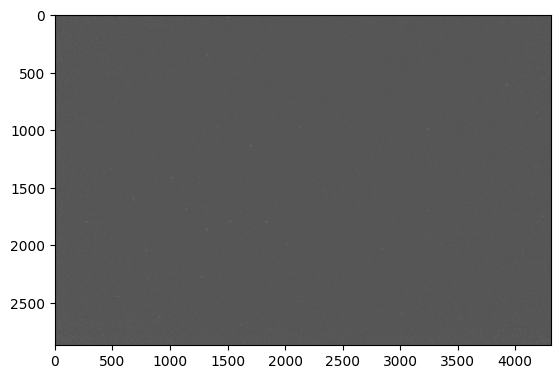

In [42]:
bahram_files = load_images(bahram_directory)
bahram_results = preprocess(master_dark, master_flat, bahram_files)

print("min :", bahram_results[0].min())
print("max :", bahram_results[0].max())
print("avg :", bahram_results[0].mean())

plt.imshow(bahram_results[0], cmap="gray")

In [43]:
# Coordinates of the same star in each image (x, y)
# i did not consider the fact that siril's y-axis is inverted so the coordinates are not correct
# but it doesn't matter since i'm using this for aligning pictures and later on i inverted "dy".
# we only care about relative shift of the images here.
star_coords = [
    (1316, 1001),
    (2060, 845),  
    (1469, 986),  
    (1797, 919),
    (1712, 954),
    (1434, 1032),
    (1679, 1000),
    (1533, 1033),
    (1804, 981),
    (1570, 1045),
    (1201, 1139),
    (1190, 1148),
    (1386, 1114),
    (1406, 1112),
    (1746, 1040),
    (1944, 992),
    (2122, 937),
    (1897, 996),
    (1667, 1063),
    (1689, 1069),
    (1655, 1080),
    (1833, 1042),
    (1444, 1138),
    (1484, 1137),
    (1490, 1147),
    (1615, 1127),
    (1926, 1057),
    (1524, 1156),
    (1772, 1101)
]

In [ ]:
def shift(image, dx, dy):
    shifted = np.zeros_like(image)
    h, w = image.shape

    src_x_start = max(0, -dx)
    src_x_end = min(w, w - dx)
    src_y_start = max(0, -dy)
    src_y_end = min(h, h - dy)

    dst_x_start = max(0, dx)
    dst_x_end = min(w, w + dx)
    dst_y_start = max(0, dy)
    dst_y_end = min(h, h + dy)

    shifted[dst_y_start:dst_y_end, dst_x_start:dst_x_end] = image[src_y_start:src_y_end, src_x_start:src_x_end]
    return shifted

def align_and_crop_to_average(calibrated_images, star_coords):
    avg_x = int(round(np.mean([x for x, y in star_coords])))
    avg_y = int(round(np.mean([y for x, y in star_coords])))

    shifts = []
    h, w = calibrated_images[0].shape

    # shifts relative to average
    for x, y in star_coords:
        dx = int(round(avg_x - x))
        dy = int(round(-(avg_y - y)))  # y-axis inverted
        shifts.append((dx, dy))

    x_start_max = 0
    y_start_max = 0
    x_end_min = w
    y_end_min = h

    for dx, dy in shifts:
        x_start = max(0, dx)
        x_end = min(w, w + dx)
        y_start = max(0, dy)
        y_end = min(h, h + dy)

        x_start_max = max(x_start_max, x_start)
        y_start_max = max(y_start_max, y_start)
        x_end_min = min(x_end_min, x_end)
        y_end_min = min(y_end_min, y_end)

    # Align and crop
    aligned_cropped = []
    for image, (dx, dy) in zip(calibrated_images, shifts):
        shifted = shift(image, dx, dy)
        cropped = shifted[y_start_max:y_end_min, x_start_max:x_end_min]
        aligned_cropped.append(cropped)

    return np.array(aligned_cropped)


def stack_aligned_images(aligned_images, method="median"):
    if method == "mean":
        return np.mean(aligned_images, axis=0)
    elif method == "median":
        return np.median(aligned_images, axis=0)

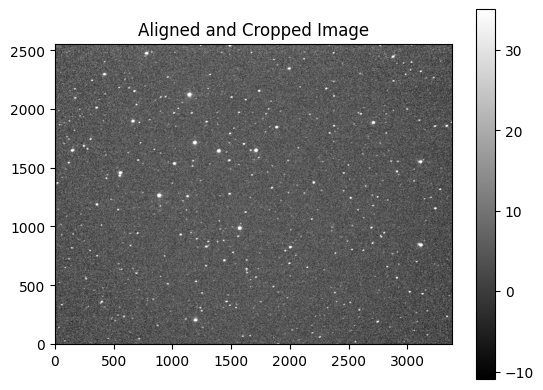

min : -48.061376277336684
max : 215.42131062691857
avg : 5.087193335561933


In [45]:
aligned_images = align_and_crop_to_average(bahram_results, star_coords)
final_image = stack_aligned_images(aligned_images, method="median")

vmin, vmax = np.percentile(final_image, [5, 99.5])
plt.imshow(final_image, cmap="gray", origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("Aligned and Cropped Image")
plt.show()

print("min :", final_image.min())
print("max :", final_image.max())
print("avg :", final_image.mean())

In [46]:
hdu = fits.PrimaryHDU(final_image)
hdu.writeto("final_stacked_image.fits", overwrite=True)

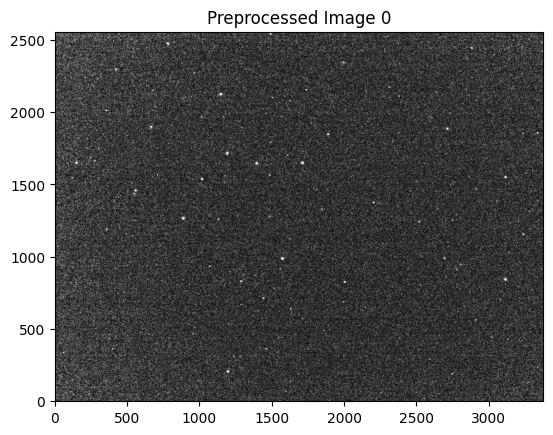

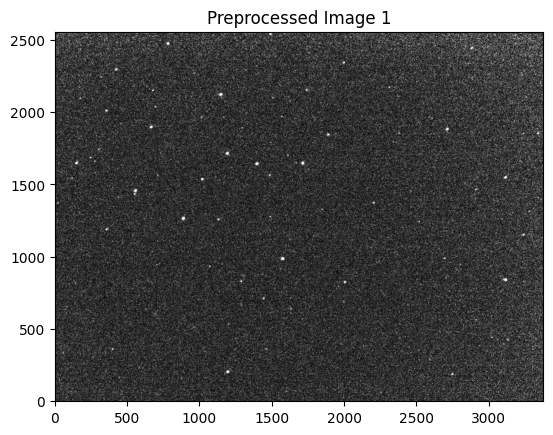

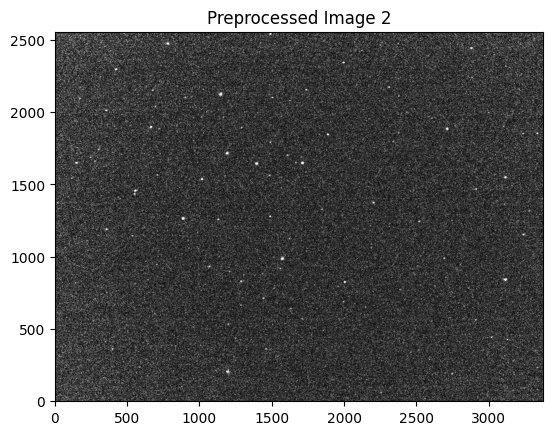

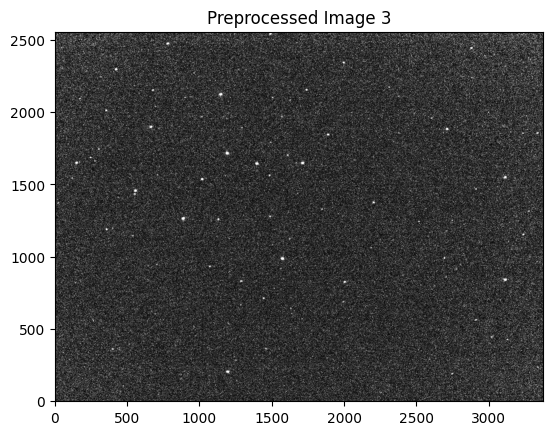

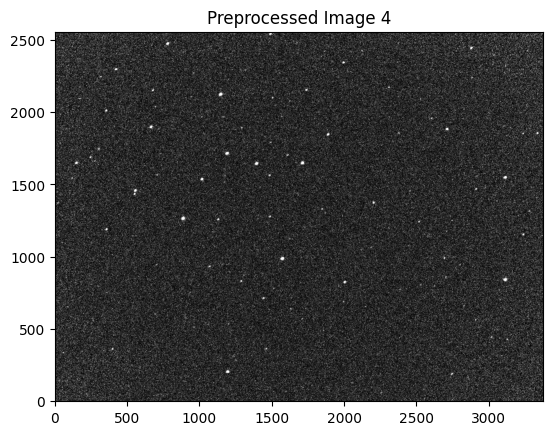

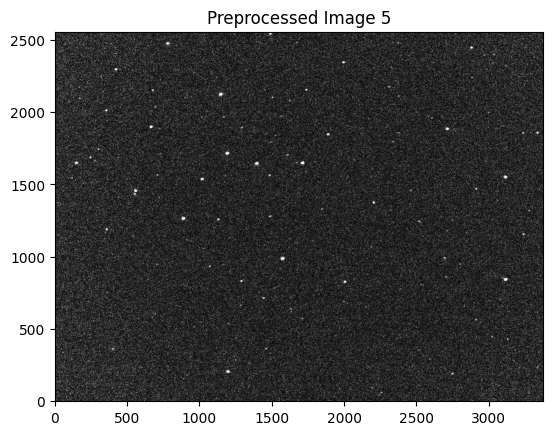

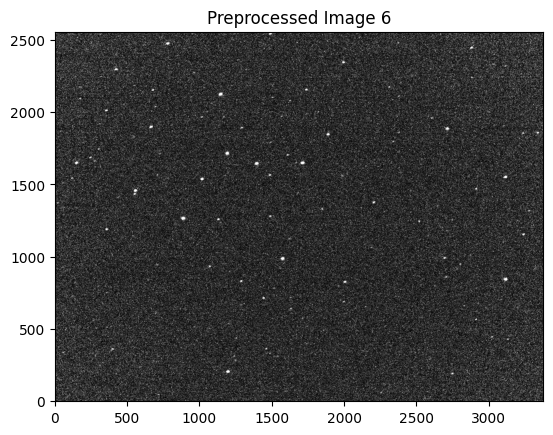

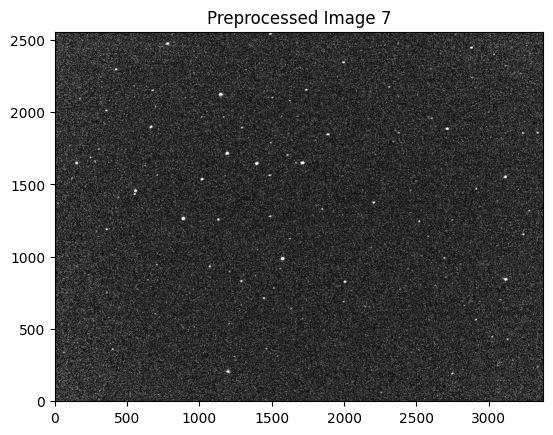

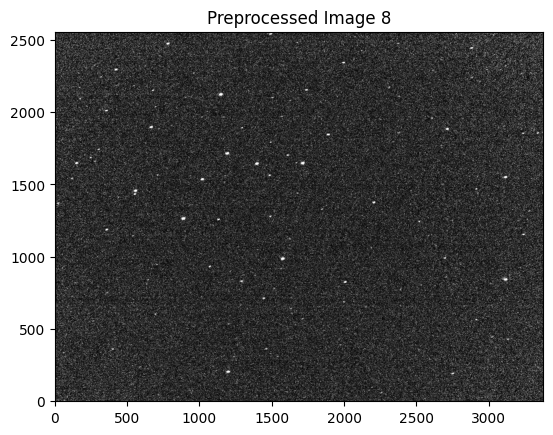

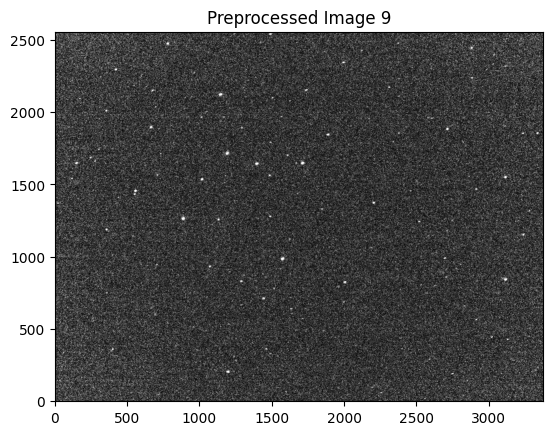

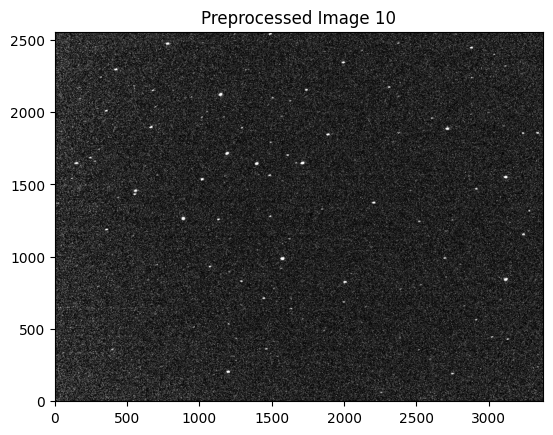

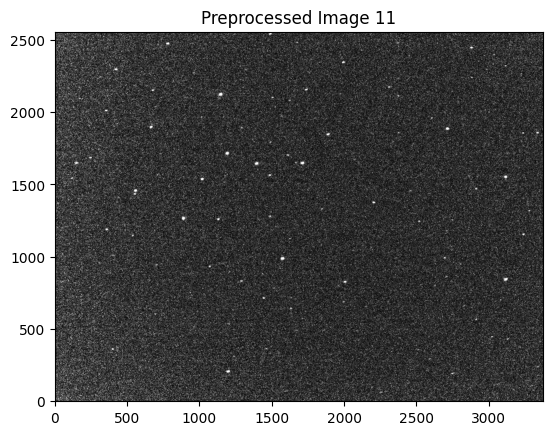

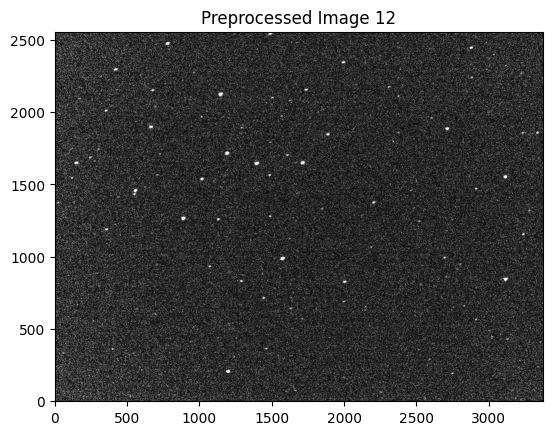

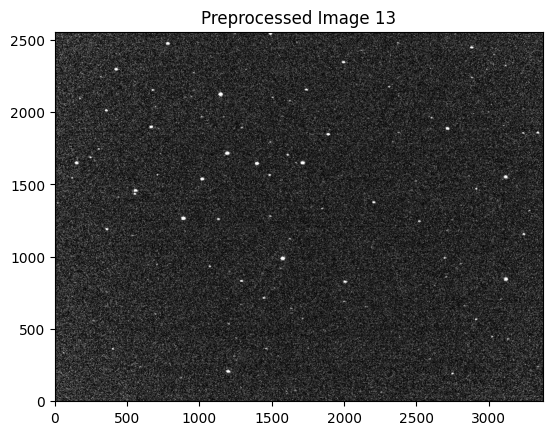

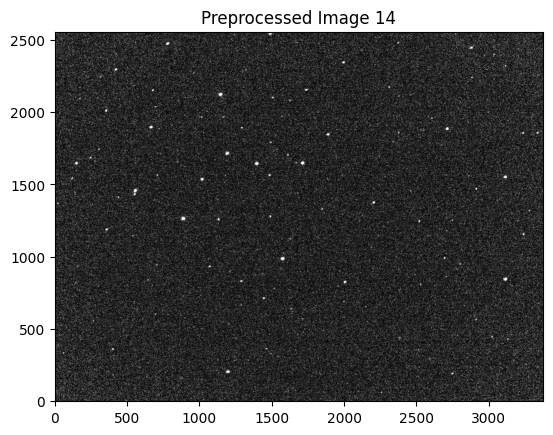

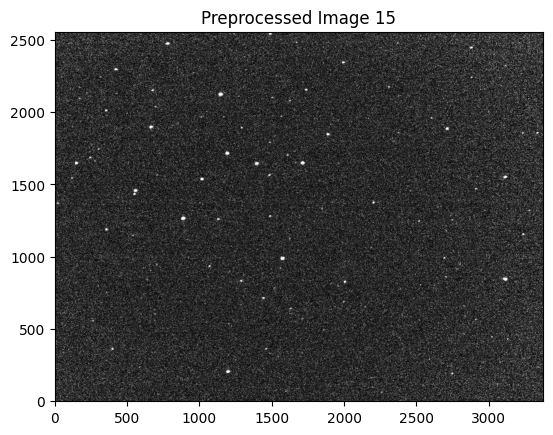

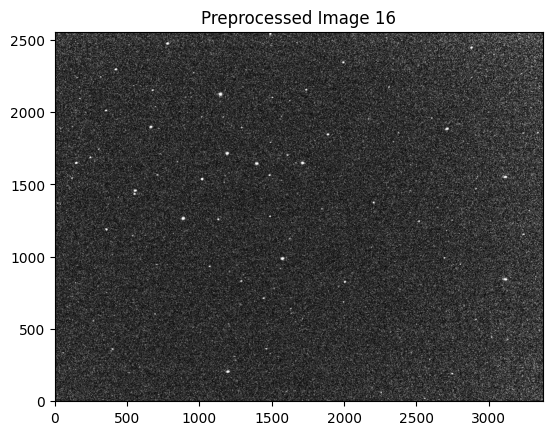

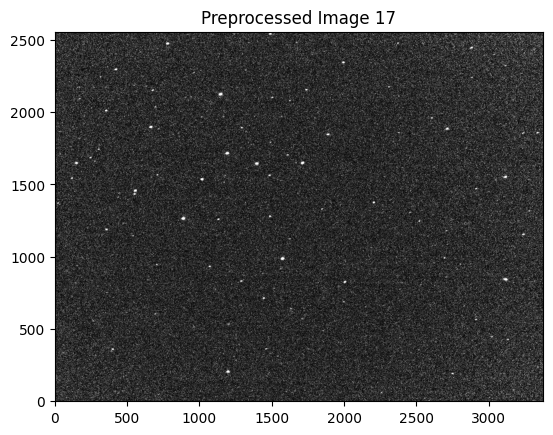

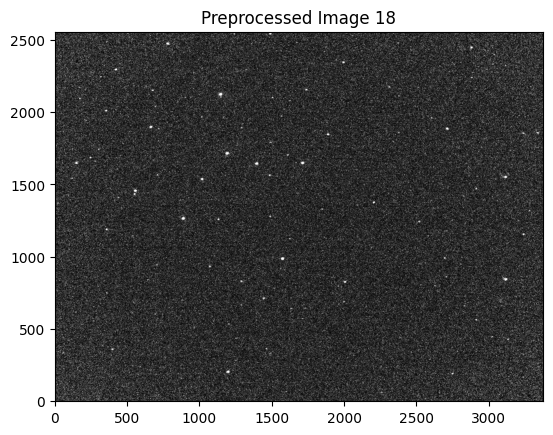

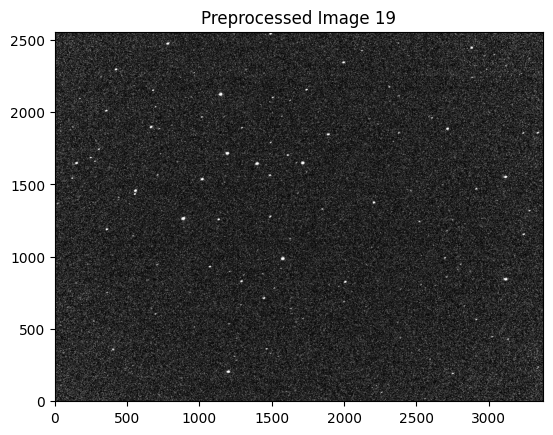

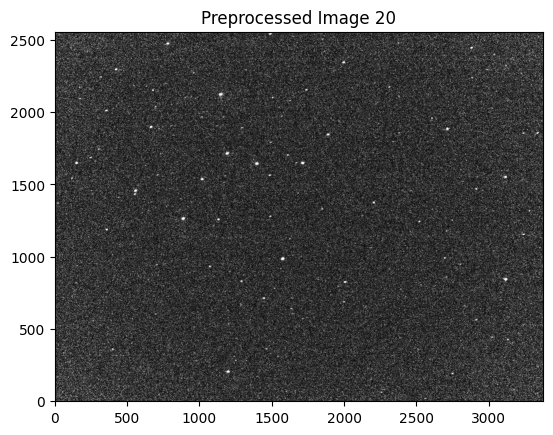

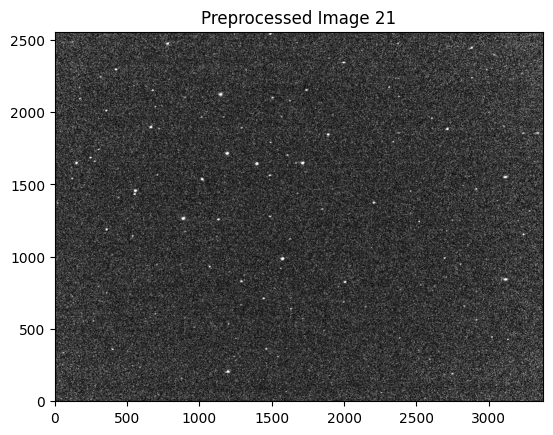

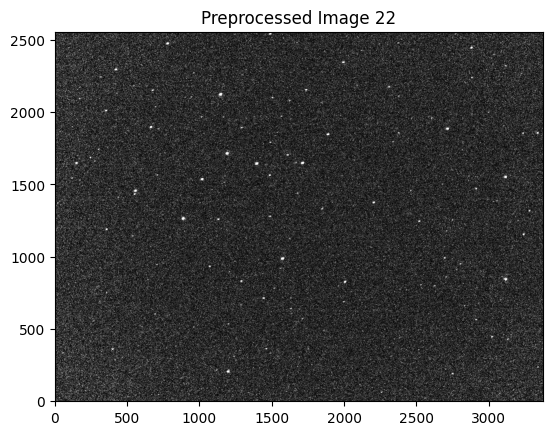

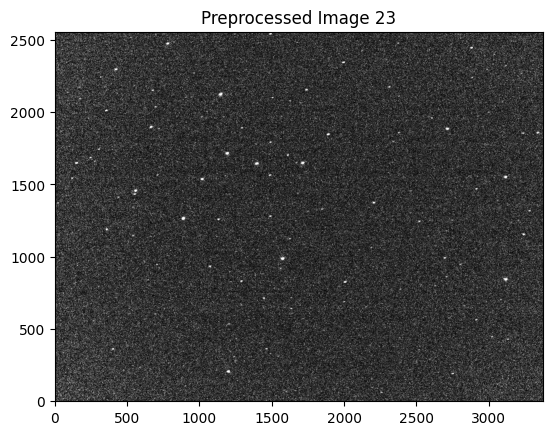

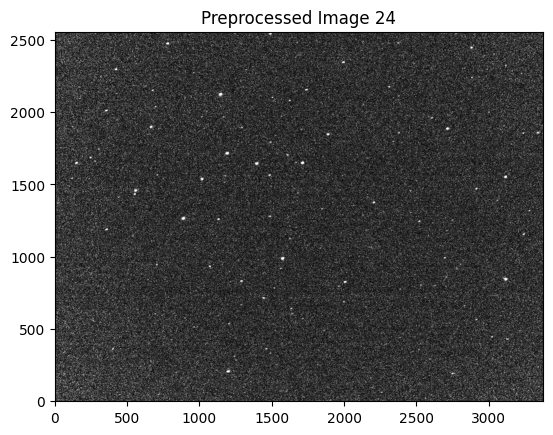

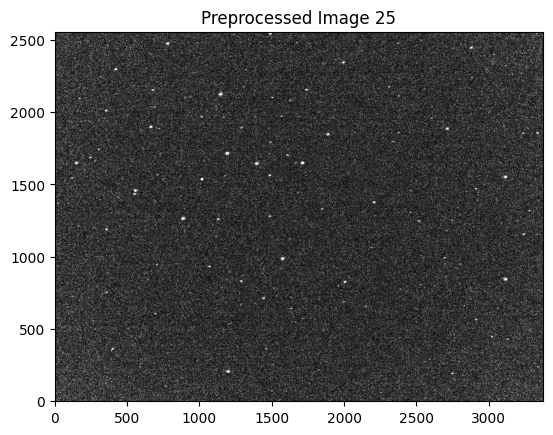

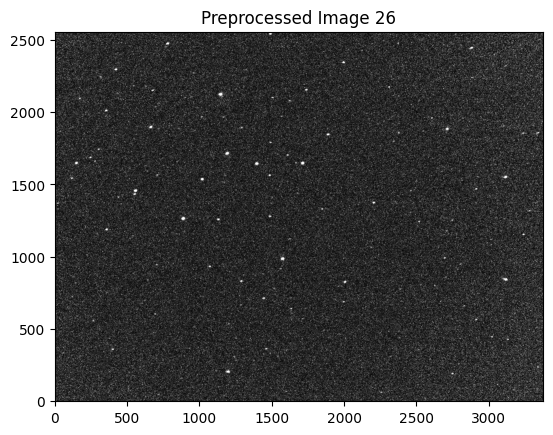

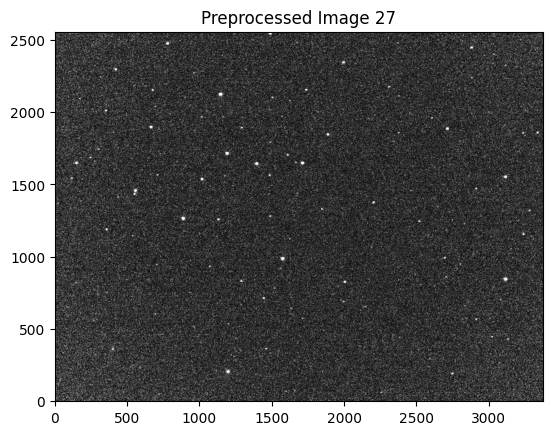

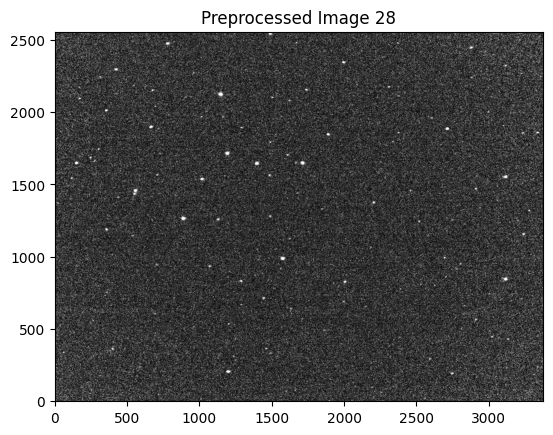

In [47]:
# Just to visualize some calibrated images
for i, img in enumerate(aligned_images[:29]):
    plt.imshow(img, cmap="gray", origin="lower", vmin=0, vmax=np.percentile(img, 99))
    plt.title(f"Preprocessed Image {i}")
    plt.show()

In [3]:
# Load FITS file
with fits.open("Teymoori_Talebi_1688_1275_V_IC-4665_29x2s_iso800_Newton8_NikonD90_20250424_Bahram.fits", mode="update") as hdul:
    hdr = hdul[0].header

    # Add or update header entries
    hdr['OBSERVER'] = 'Teymoori_Talebi'
    hdr['OBJECT'] = 'IC-4665'
    hdr['FILTER'] = 'V'
    hdr['EXPOSURE'] = 29
    hdr['EXPTIME'] = 2          
    hdr['TOTALEXP'] = 2 * 29    
    hdr['ISO'] = 800
    hdr['TELESCOP'] = 'Newton8'
    hdr['INSTRUME'] = 'NikonD90'
    hdr['DATE-OBS'] = '2025-4-24'  
    hdr['LOCATION'] = 'Bahram'
    hdr['CENTX'] = 1688
    hdr['CENTY'] = 1275


    # Save changes
    hdul.flush()


In [4]:
print(repr(hdr))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3378                                                  
NAXIS2  =                 2557                                                  
EXTEND  =                    T                                                  
OBSERVER= 'Teymoori_Talebi'                                                     
OBJECT  = 'IC-4665 '                                                            
FILTER  = 'V       '                                                            
HIERARCH EXPOSURES = 29                                                         
EXPTIME =                    2                                                  
TOTALEXP=                   58                                                  
ISO     =                  8